# Data Science Bowl 2019

# Introduction

PBS KIDS, a trusted name in early childhood education for decades, aims to gain insights into how media can help children learn important skills for success in school and life. In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

**Where does the data for the competition come from?**
The data used in this competition is anonymous, tabular data of interactions with the PBS KIDS Measure Up! app. Select data, such as a user’s in-app assessment score or their path through the game, is collected by the PBS KIDS Measure Up! app, a game-based learning tool.

**What is the PBS KIDS Measure Up! app?**
In the PBS KIDS Measure Up! app, children ages 3 to 5 learn early STEM concepts focused on length, width, capacity, and weight while going on an adventure through Treetop City, Magma Peak, and Crystal Caves. Joined by their favorite PBS KIDS characters, children can also collect rewards and unlock digital toys as they play. 

Besides the info provided above by Kaggle, I found the following additional info on the website of the app:

Specific features of Measure Up! include:

* 19 unique measuring games.
* 10 measurement-focused video clips.
* Sticker books featuring favorite PBS KIDS characters.
* Rewards for completion of tasks.
* Embedded challenges and reports to help parents and caregivers monitor kids’ progress.
* Ability to track your child's progress using the PBS KIDS Super Vision companion app.

**Evaluation**
Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved



For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

# Table of contents

* [1. Understanding the train data](#1.-Understanding-the-train-data)
* [2. Understanding the test set](#2.-Understanding-the-test-set)
* [3. Understanding and visualizing the train labels](#3.-Understanding-and-visualizing-the train-labels)
* [4. Feature engineering and visualizations](#4.-Feature-engineering-and-visualizations)

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%time
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')
specs = pd.read_csv('specs.csv')
sample_sub = pd.read_csv('sample_submission.csv')

Wall time: 59.8 s


# 1. Understanding the train data

In [4]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
train.shape

(11341042, 11)

So we have 11 million rows and just 11 columns. However, Kaggle provided the following note: Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

As there is no point in keeping training data that cannot be used for training anyway, I am getting rid of the installation_ids that never took an assessment
    

In [6]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

As you can see, we have now lost about 3 million rows.

In [7]:
train.shape

(8294138, 11)

The number of unique installations in our "smaller" train set is now 4242.

In [8]:
keep_id.shape

(4242, 1)

I will first visualize some of the existing columns.

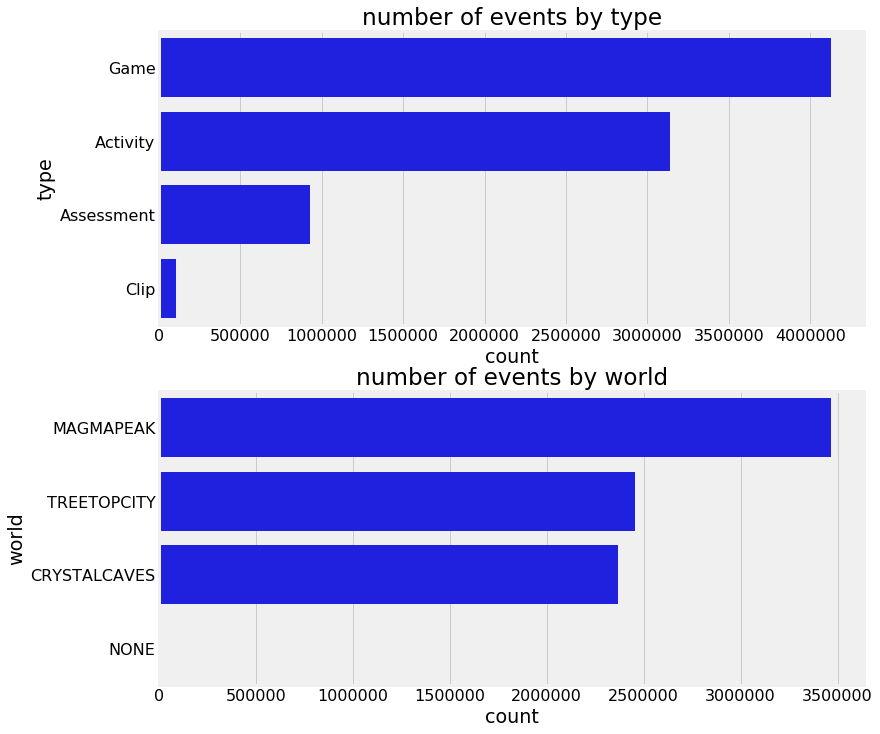

In [9]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, color="blue", order = train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, color="blue", order = train.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

I will now add some new columns based on the timestamp, and visualize these.

In [10]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df
    
train = get_time(train)

#list(set(train['title'].unique()).union(set(test['title'].unique())))

Below your see the counts by date. By the way, I have wasted a lot of time on trying to fix the weird ticks on the x-axis, but this seems a bug: https://github.com/matplotlib/matplotlib/issues/13183

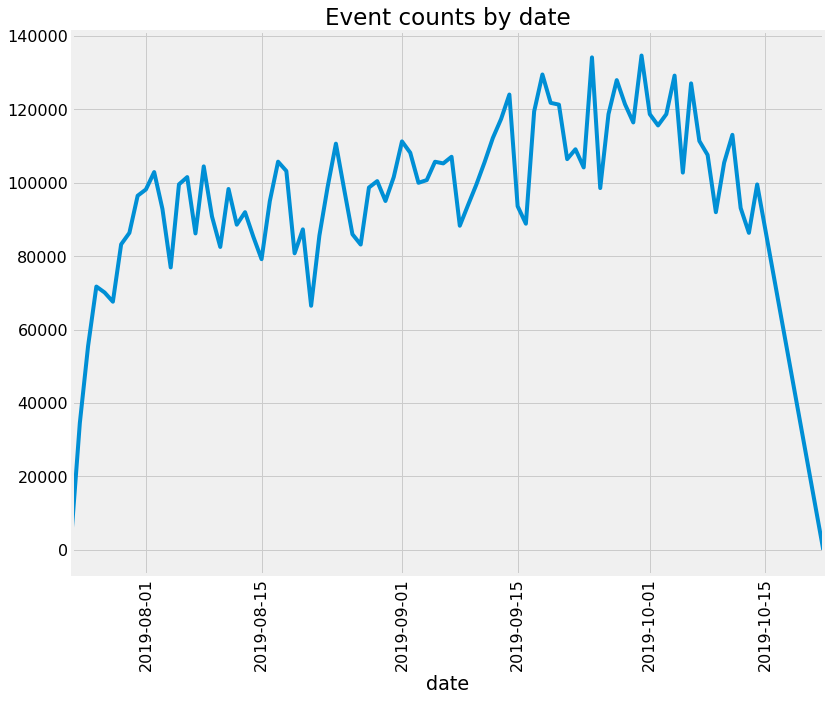

In [11]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title("Event counts by date")
plt.xticks(rotation=90)
plt.show()

When looking at the day of the week, we see no major difference. Of course, we are talking about kids who don't have to go to work ;-)

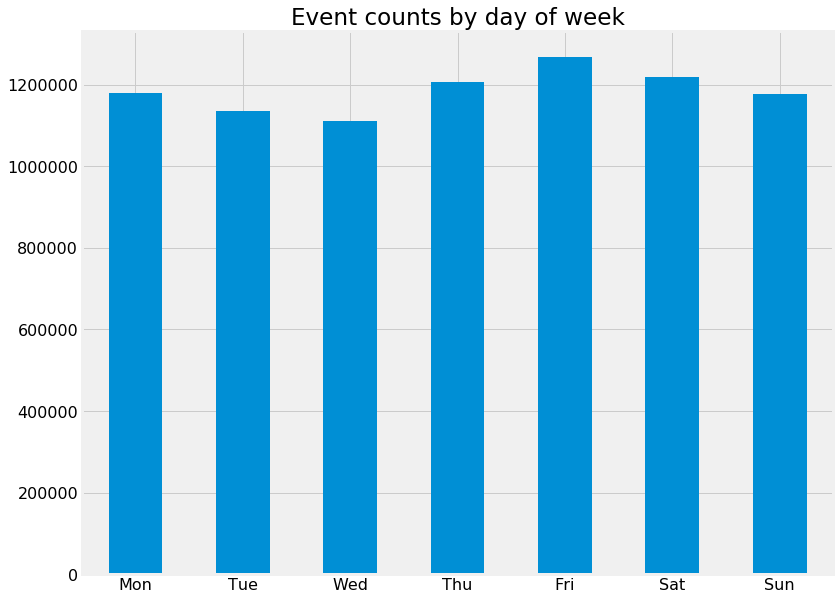

In [12]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by day of week")
plt.xticks(rotation=0)
plt.show()

When looking at the numbers by hour of the day, I find the distribution a little bit strange. Kids seem up late at night and don't do much early in the morning. Has this something to do with time zones perhaps?

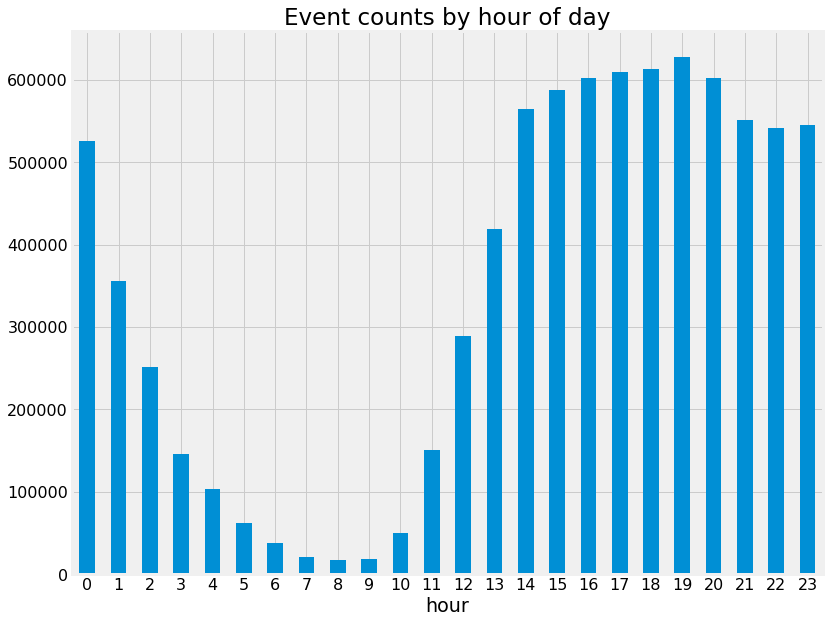

In [13]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('hour')['hour'].count()
#se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)
plt.show()

# 2. Understanding the test set

From Kaggle: For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

In [14]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [15]:
test.shape

(1156414, 11)

In [16]:
test.installation_id.nunique()

1000

So we have 1.1 million rows on a thousand unique installation_ids in the test set. Below, you can see that we have this same amount of rows in the sample submission. This means that there are no installation_ids without assessment in the test set indeed.

In [17]:
sample_sub.shape

(1000, 2)

# 3. Understanding and visualizing the train labels

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved


I started by visualizing some of these columns

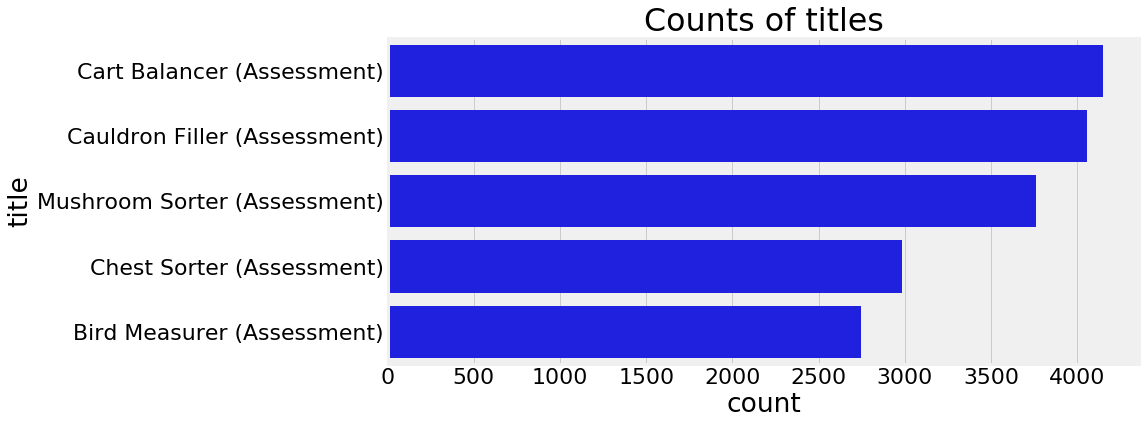

In [18]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")
plt.show()

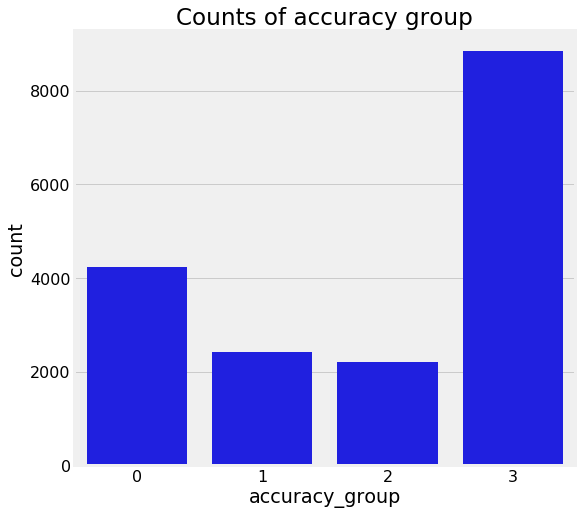

In [19]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,8))
sns.countplot(x="accuracy_group", data=train_labels, color="blue")
plt.title("Counts of accuracy group")
plt.show()

As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [20]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [21]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1


After having read Andrew Lukyanenko's notebook, I decided to also create an attempt variable. In addition, I have also borrowed his code to extract the correct variable (thanks Andrew!).

In [22]:
#credits for this code chuck go to Andrew Lukyanenko
train['attempt'] = 0
train.loc[(train['title'] == 'Bird Measurer (Assessment)') & (train['event_code'] == 4110),\
       'attempt'] = 1
train.loc[(train['type'] == 'Assessment') &\
       (train['title'] != 'Bird Measurer (Assessment)')\
       & (train['event_code'] == 4100),\
          'attempt'] = 1

train['correct'] = None
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":true')), 'correct'] = True
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":false')), 'correct'] = False

Below you can see that row 2615 is not in the assessment results of this installation_id anymore, and the results add up nicely to the num_correct and num_incorrect in the train_labels.

In [23]:
train[(train.installation_id == "0006a69f") & (train.attempt == 1)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False


Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 of those.

In [24]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

As we can not train on those installation_id's anyway, I am taking them out of the train set. This reduces our train set further from 8.3 million rows to 7.7 million.

In [25]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 17)

# 4. Feature engineering; adding features to train_labels

Basically what we need to do is add features to the train_labels dataframe to get our training dataset. To be continued in the next version. Please stay tuned!

**To be continued**

In [26]:
Type = test["type"].str.get_dummies(" ") 
Type.head()

Type.shape


(1156414, 4)

In [27]:
test['Clip'] = Type['Clip']
test['Game'] = Type['Game']
test['Activity'] = Type['Activity']
test['Assessment'] = Type['Assessment']

test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,Clip,Game,Activity,Assessment
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,1,0,0,0
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,1,0,0,0
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,1,0,0,0
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,1,0,0,0
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES,0,1,0,0


In [28]:
World = test["world"].str.get_dummies(" ") 
World.head()


,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,1,0,0,0
4,1,0,0,0


In [29]:
test['CRYSTALCAVES'] = World['CRYSTALCAVES']
test['MAGMAPEAK'] = World['MAGMAPEAK']
test['NONE'] = World['NONE']
test['TREETOPCITY'] = World['TREETOPCITY']

test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,1,0,0,0,0,0,1,0
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,1,0,0,0,0,1,0,0
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,1,0,0,0,0,1,0,0
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,1,0,0,0,1,0,0,0
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES,0,1,0,0,1,0,0,0


In [30]:
Train_Type = train["type"].str.get_dummies(" ") 
Train_World = train["world"].str.get_dummies(" ") 

In [31]:
train['Clip'] = Train_Type['Clip']
train['Game'] = Train_Type['Game']
train['Activity'] = Train_Type['Activity']
train['Assessment'] = Train_Type['Assessment']

train['CRYSTALCAVES'] = Train_World['CRYSTALCAVES']
train['MAGMAPEAK'] = Train_World['MAGMAPEAK']
train['NONE'] = Train_World['NONE']
train['TREETOPCITY'] = Train_World['TREETOPCITY']

train.head()


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1,0,None,1,0,0,0,0,0,1,0
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1,0,None,1,0,0,0,0,1,0,0
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0


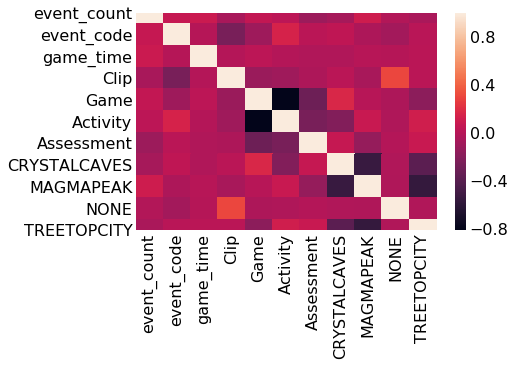

In [32]:
corr = test.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [33]:
#from sklearn.preprocessing import StandardScaler
#sc= StandardScaler()

#X = train['game_time', 'Game', 'Activity','Assessment', 'MAGMAPEAK', 'CRYSTALCAVES','TREETOPCITY' ]
#y = 

#sc.fit_transform(X)


In [34]:
#from sklearn.linear_model import LinearRegression

#lm = LinearRegression()
#model = lm.fit(X_train,y_train)

In [35]:
#from sklearn import metrics
#import statsmodels.formula.api as smf
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#predictions = lm.predict(X_test)

In [36]:
#rms = sqrt(mean_squared_error(y_test, predictions))

#print(rms)

In [37]:
#import statsmodels.api as sm
#from scipy import stats

#Predictors = sm.add_constant(X_train)
#est = sm.OLS(y_train,Predictors)
#est2 = est.fit()
#print(est2.summary(title='Original Model',xname=['game_time', 'Game', 'Activity','Assessment', 'MAGMAPEAK', 'CRYSTALCAVES','TREETOPCITY']


In [38]:
ids_with_subms = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
raw_train = pd.merge(train, ids_with_subms, on="installation_id", how="inner")

In [39]:
len(raw_train)

7734558

In [40]:
train_labels = pd.read_csv('train_labels.csv')

train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [41]:
train['accuracy_group'] = train.game_session.map(train_labels.set_index('game_session')['accuracy_group'].to_dict())



In [42]:
test['accuracy_group'] = test.game_session.map(train_labels.set_index('game_session')['accuracy_group'].to_dict())


In [43]:
raw_train['accuracy_group'] = raw_train.game_session.map(train_labels.set_index('game_session')['accuracy_group'].to_dict())

In [44]:
success = raw_train[raw_train.event_code.isin([4110, 4100])]

In [45]:
success['accuracy_group'].value_counts()

0.0    16349
1.0    13059
3.0     9642
2.0     4848
Name: accuracy_group, dtype: int64

In [46]:
test_list = train['game_session']

In [47]:
corr = test.corr()

print(corr)


                event_count  event_code  game_time      Clip      Game  \
event_count        1.000000    0.070044   0.087223 -0.057826  0.051454   
event_code         0.070044    1.000000   0.000644 -0.257366 -0.098091   
game_time          0.087223    0.000644   1.000000 -0.012942  0.026528   
Clip              -0.057826   -0.257366  -0.012942  1.000000 -0.114429   
Game               0.051454   -0.098091   0.026528 -0.114429  1.000000   
Activity           0.023013    0.147086  -0.008620 -0.095029 -0.813551   
Assessment        -0.106962    0.021990  -0.026578 -0.036079 -0.308878   
CRYSTALCAVES      -0.066318    0.037214  -0.022675  0.019733  0.167970   
MAGMAPEAK          0.104761   -0.036855   0.002868 -0.058833  0.007745   
NONE              -0.017667   -0.078631  -0.003954  0.305522 -0.034961   
TREETOPCITY       -0.048590    0.010099   0.019388  0.021407 -0.170424   
accuracy_group          NaN         NaN        NaN       NaN       NaN   

                Activity  Assessment 

In [48]:
train_assessment = train[(train.event_code == 4100) | (train.event_code == 4110)]

In [49]:
train_assessment.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True,0,0,0,1,0,0,0,1,3.0
737,dcb55a27,80d34a30c2998653,2019-08-06 05:24:05.811000+00:00,"{""distance"":8,""round"":0,""event_count"":43,""game...",0006a69f,43,4110,69853,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1,0,None,0,1,0,0,0,0,0,1,NaN
750,dcb55a27,80d34a30c2998653,2019-08-06 05:24:24.726000+00:00,"{""distance"":10,""round"":0,""event_count"":56,""gam...",0006a69f,56,4110,88771,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1,0,None,0,1,0,0,0,0,0,1,NaN
770,14de4c5d,80d34a30c2998653,2019-08-06 05:24:50.323000+00:00,"{""distance"":10,""target_distances"":[5,6,7,8,9,1...",0006a69f,76,4100,114370,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1,0,None,0,1,0,0,0,0,0,1,NaN
797,14de4c5d,80d34a30c2998653,2019-08-06 05:25:11.292000+00:00,"{""distance"":9,""target_distances"":[5,6,7],""corr...",0006a69f,103,4100,135341,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1,0,None,0,1,0,0,0,0,0,1,NaN


In [50]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1,0,None,1,0,0,0,0,0,1,0,NaN
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1,0,None,1,0,0,0,0,1,0,0,NaN
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0,NaN
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1,0,None,0,0,1,0,0,1,0,0,NaN


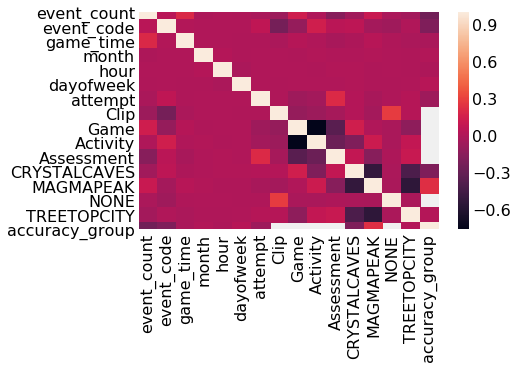

In [51]:
corr = train.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [52]:
train_assessment.to_csv('train_assessment.csv')

In [53]:
train_assessment = train_assessment[(train_assessment.type == 'Assessment')]

In [54]:
train_assessment.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True,0,0,0,1,0,0,0,1,3.0
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0


In [55]:
title = train_assessment.groupby('title')

In [56]:
title.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True,0,0,0,1,0,0,0,1,3.0
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1259,25fa8af4,6bdf9623adc94d89,2019-08-06 05:38:08.036000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,30,4100,18026,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True,0,0,0,1,0,0,0,1,3.0
2187,25fa8af4,9501794defd84e4d,2019-08-06 20:35:12.290000+00:00,"{""correct"":false,""stumps"":[3,2,5],""event_count...",0006a69f,29,4100,18484,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1,1,False,0,0,0,1,0,0,0,1,2.0
2196,25fa8af4,9501794defd84e4d,2019-08-06 20:35:16.846000+00:00,"{""correct"":true,""stumps"":[2,3,5],""event_count""...",0006a69f,38,4100,23043,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1,1,True,0,0,0,1,0,0,0,1,2.0
5362,392e14df,197a373a77101924,2019-09-14 15:35:54.361000+00:00,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",0006c192,20,4100,12635,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-09-14,9,15,5,1,True,0,0,0,1,0,1,0,0,3.0


In [57]:
bird_measurer = train_assessment[(train_assessment.title == 'Bird Measurer (Assessment)')]
bird_measurer.head()
bird_measurer.shape

(13510, 26)

In [58]:
bm = bird_measurer.groupby('game_session')

In [59]:
bm.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8283730,17113b36,967f050913e025e7,2019-08-30 13:18:15.871000+00:00,"{""correct"":false,""caterpillars"":[3,8,5],""event...",ff9305d7,29,4110,25197,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-30,8,13,4,1,False,0,0,0,1,0,0,0,1,1.0
8283741,17113b36,967f050913e025e7,2019-08-30 13:18:24.573000+00:00,"{""correct"":true,""caterpillars"":[4,8,5],""event_...",ff9305d7,40,4110,33897,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-30,8,13,4,1,True,0,0,0,1,0,0,0,1,1.0
8283765,070a5291,967f050913e025e7,2019-08-30 13:18:50.092000+00:00,"{""correct"":false,""hats"":[4,5,8],""event_count"":...",ff9305d7,64,4100,59417,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-30,8,13,4,0,None,0,0,0,1,0,0,0,1,1.0
8288381,17113b36,c996482b11d149dd,2019-07-29 21:23:59.148000+00:00,"{""correct"":true,""caterpillars"":[4,8,5],""event_...",ffc90c32,25,4110,31356,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-07-29,7,21,0,1,True,0,0,0,1,0,0,0,1,3.0


In [60]:
## Creating dictionary of the value counts of the unique game_sessions and the installation_ids

count_game_session = bird_measurer.game_session.value_counts().to_dict()
user_attempts = bird_measurer.installation_id.value_counts().to_dict()

#Had to do it using the bird_measurer dataframe, since it doesn't work with groupby

In [61]:
bird_measurer['session_counts'] = bird_measurer['game_session'].map(count_game_session)
bird_measurer['user_attempts'] = bird_measurer['installation_id'].map(user_attempts)
bird_measurer.head()
## Added new columns at the end called 'session_counts' and 'user_attempts' to add these in

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group,session_counts,user_attempts
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0,11,13
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0,11,13
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0,11,13
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0,11,13
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False,0,0,0,1,0,0,0,1,0.0,11,13


In [62]:
bm = bird_measurer.sort_values(by = ['game_session', 'game_time'], ascending = False)
# sorted the df by game_session and then by game time (descending so our largest value appears first) 

In [63]:
## Dropped duplicates, keeping only the first iteration (the one with the highest game_time)
bm.drop_duplicates(subset='game_session', keep='first', inplace=False)

# This dataframe has 2748 rows and the number of unique values in game_session is 2748, so I think we've got it!!

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct,Clip,Game,Activity,Assessment,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,accuracy_group,session_counts,user_attempts
2622870,070a5291,fff53215178ede64,2019-10-13 02:12:42.565000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",4db1e993,31,4100,37904,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-10-13,10,2,6,0,None,0,0,0,1,0,0,0,1,3.0,2,6
7889340,070a5291,ffe2dd9f076db064,2019-08-07 22:14:57.782000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":4...",f3e09002,43,4100,39613,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-07,8,22,2,0,None,0,0,0,1,0,0,0,1,3.0,2,10
1995394,070a5291,ffe143fdf421a715,2019-10-11 22:32:19.457000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":7...",3bb92342,74,4100,93029,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-10-11,10,22,4,0,None,0,0,0,1,0,0,0,1,3.0,2,2
7535309,17113b36,ffaef1d382039db8,2019-10-06 19:55:56.763000+00:00,"{""correct"":false,""caterpillars"":[2,2,2],""event...",ea49ea9c,5,4110,5047,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-10-06,10,19,6,1,False,0,0,0,1,0,0,0,1,0.0,1,74
5487374,17113b36,ffa86aecc8f31c1f,2019-09-10 22:30:52.834000+00:00,"{""correct"":false,""caterpillars"":[2,2,2],""event...",a780cada,4,4110,3519,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-09-10,9,22,1,1,False,0,0,0,1,0,0,0,1,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468072,070a5291,0060b5da47c841d3,2019-09-17 00:44:16.197000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":1...",4b02b17f,107,4100,139224,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-09-17,9,0,1,0,None,0,0,0,1,0,0,0,1,3.0,9,30
8243397,17113b36,0024681d73e46aca,2019-08-31 13:59:37.062000+00:00,"{""correct"":false,""caterpillars"":[2,2,2],""event...",fd5385c7,7,4110,8650,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-31,8,13,5,1,False,0,0,0,1,0,0,0,1,0.0,1,2
7167866,070a5291,002396a496a0c1c7,2019-10-07 18:18:56.213000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":4...",daed707d,41,4100,44491,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-10-07,10,18,0,0,None,0,0,0,1,0,0,0,1,3.0,2,2
795787,070a5291,001c49e9e9968dbe,2019-07-26 15:51:13.098000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":4...",19d4b097,41,4100,36875,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-07-26,7,15,4,0,None,0,0,0,1,0,0,0,1,2.0,3,5
